# French Electric Mix in 2019

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sn 
%matplotlib inline 
plt.style.use('ggplot')

* https://opendata.reseaux-energies.fr/pages/accueil/
* https://bilan-electrique-2019.rte-france.com/
* https://transparency.entsoe.eu/

# Module construction production & demande 

> Données entrée : 
* Courbe de demande 
* Courbe de production 
* Capacité installée de chaque filière
* Demande nette fournit imports/exports





# Reconstruire la courbe 

In [2]:
hours = [i for i in range(24)]

demande = [50,45,40,40,40,40,40,40,40,45,50,55,60,60,60,70,70,70,65,60,57,53,50,50]
capacity = [30,20,10,5]

calculer ce qu'il faut combler, prendre à chaque heure, division euclidienne de la valeur


In [3]:
def dispatch(demande, capacity):
    capacity.sort(reverse=True)
    # Il faut d'abord créer le dispatch, pour cela on utilise une matrice afin de savoir quelle unité sont utilisée à quelle heure
    mat = np.zeros((len(capacity)+1,24))
    capacities = np.zeros((len(capacity)+1,24))
    for (i,d) in enumerate(demande) : 
        # Pour chaque demande horaire, nous devons calculer le dispatch adéquat
        r = d 
        j = 0
        while r!=0 and j<len(capacity) :
                if capacity[j] < r:
                    # Cette capacité n'est pas suffisante pour répondre à la demande
                    r = r-capacity[j]
                    mat[j][i] = 1
                else :
                    # La capacité  est supérieure à ce dont nous avons besoin on n'en utilisera qu'une partie 
                    r = 0
                    mat[j][i] = 1
                    # signifie que nous allons exporter l'énergie résiduelle 
                    mat[len(capacity)][i] = -1

                j+=1
        if r!=0:
            mat[len(capacity)][i] = 1
    #Ensuite on créé les vecteurs qui vont nous permettre d'afficher le dispatch
    for i in range(len(hours)):
        #### On parcourt chaque heure
        maxcap_h = 0 #Permet de savoir quelle est le niveau minimum de production pour chaque heure utile pour tracer
        for j in range(len(capacity)+1):
            if j!=len(capacity):
                if mat[j][i] !=0:
                    capacities[j][i] = sum(capacity[:j+1]) #On définit la capacité
                    maxcap_h = capacities[j][i]
                else :
                    capacities[j][i] = maxcap_h

            else : 
                if mat[j][i]!=0:
                    # Les unités de production ne sont pas suffisante, ou trop importantes, il faut importer // exporter
                    capacities[j][i] = (demande[i]-sum(capacity))
    plot_dispatch(demande,capacity,capacities,mat)
    return(mat,capacities)

## Capacity to draw

In [11]:
def plot_dispatch(demande,capacity,capacities,mat):
    hours = np.array([i for i in range(24)])
    colors = ['orange',"gray",'blue','yellow','green']
    labels = ["Nucléaire","Thermique","Eolien","Solaire"]
    plt.figure(figsize=(10,10))
    plt.plot(hours,demande,label="Demande",linewidth = 7)
    plt.ylabel('kMW')
    plt.xlabel('Heures')

    for i in range(len(capacity)):
        if i ==0:
            plt.fill_between(hours,capacities[i][:],color=colors[i],label=labels[i])
        else : 
            plt.fill_between(hours,capacities[i-1][:],capacities[i][:],color=colors[i],label=labels[i])
    # Plot import & Export
    # Export
    imp_exp = capacities[len(capacity)-1][:]
    plt.fill_between(hours,imp_exp,demande,where = imp_exp>=demande,color='pink',label=f'Export')
    #Import 
    plt.fill_between(hours,imp_exp,demande,where = demande>=imp_exp, color='cyan',label=f'Import')
    plt.title(f'Dispatch avec {len(capacity)} outils de production')
    plt.legend(loc='upper left')

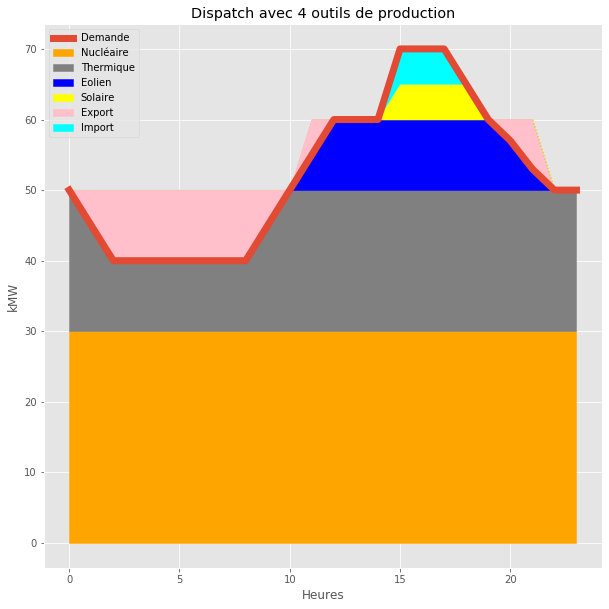

In [12]:
mat,capacities = dispatch(demande,capacity)

In [7]:
capacity2 = [25,20]

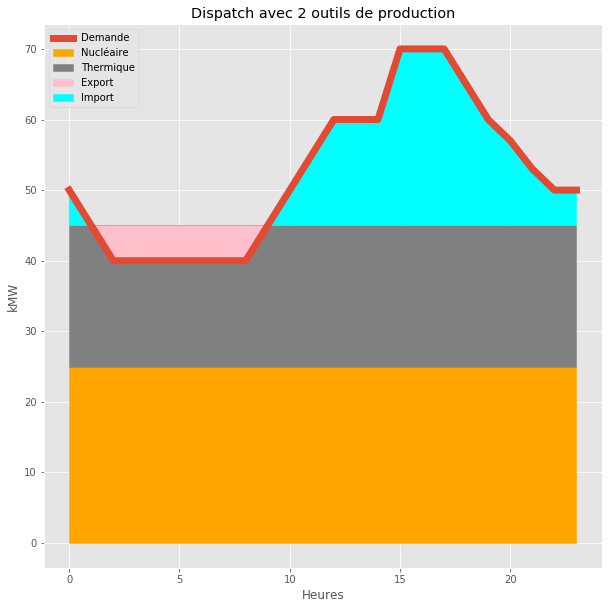

In [8]:
mat2,cap2 = dispatch(demande,capacity2)

## Read real data from 2020/01/01

### Consommation

In [41]:
conso = pd.read_excel('consommation-quotidienne-brute.xlsx')

In [42]:
conso["Date - Heure"] = pd.to_datetime(conso["Date - Heure"])

In [43]:
conso = conso[conso.Date=='01/01/2020']
conso = conso.sort_values(by='Date - Heure').reset_index(drop=True)


In [44]:
conso.head(2)

,Date - Heure,Date,Heure,Consommation brute électricité (MW) - RTE
0,2020-01-01 00:00:00+01:00,01/01/2020,00:00,67104
1,2020-01-01 00:30:00+01:00,01/01/2020,00:30,65916


### Production

In [45]:
prod = pd.read_excel('production-quotidienne-filiere.xlsx')

In [47]:
prod["Date - Heure"] = pd.to_datetime(prod["Date - Heure"])
prod = prod.sort_values(by='Date - Heure').reset_index(drop=True)

In [53]:
prod = prod.replace({-1:0}) #-1 quand pas de production -> 0 

In [69]:
col_prod = prod.columns[3:]

In [70]:
# Besoin de reorganiser le df

In [76]:
order_col = prod[col_prod].mean().sort_values(ascending=False).index
df = prod[order_col[1:]]

In [77]:
df.head()

,Production nucléaire (MW),Production hydraulique (MW),Production thermique fossile (MW),Production gaz (MW),Production éolienne (MW),Production bioénergies (MW),Production solaire (MW),Production fioul (MW),Production charbon (MW)
0,49227,9072,6885,6502,3716,1209,0,351,32
1,49437,9554,6722,6394,3571,1165,0,316,12
2,48970,9102,6284,5970,3144,1159,0,301,13
3,49648,9093,5663,5364,2924,1158,0,285,14
4,49764,8667,5368,5251,2739,1169,0,104,13


In [97]:
cumul

[[], [], [], [], [], [], [], [], []]

In [174]:
49227+9072+6885

65184

In [170]:
df.iloc[:5,:3]

,Production nucléaire (MW),Production hydraulique (MW),Production thermique fossile (MW)
0,49227,9072,6885
1,49437,9554,6722
2,48970,9102,6284
3,49648,9093,5663
4,49764,8667,5368


In [173]:
df.iloc[:5,:3].cumsum(axis=1)

,Production nucléaire (MW),Production hydraulique (MW),Production thermique fossile (MW)
0,49227,58299,65184
1,49437,58991,65713
2,48970,58072,64356
3,49648,58741,64404
4,49764,58431,63799


In [177]:
df

,Production nucléaire (MW),Production hydraulique (MW),Production thermique fossile (MW),Production gaz (MW),Production éolienne (MW),Production bioénergies (MW),Production solaire (MW),Production fioul (MW),Production charbon (MW)
0,49227,9072,6885,6502,3716,1209,0,351,32
1,49437,9554,6722,6394,3571,1165,0,316,12
2,48970,9102,6284,5970,3144,1159,0,301,13
3,49648,9093,5663,5364,2924,1158,0,285,14
4,49764,8667,5368,5251,2739,1169,0,104,13
5,49747,8180,4526,4408,2704,1156,0,104,14
6,49527,7623,3690,3573,2753,1157,0,104,13
7,49887,7301,2973,2856,2764,1166,0,104,13
8,49299,6987,2968,2852,2696,1173,0,104,12
9,49714,6573,2993,2876,2686,1170,0,104,13


In [176]:
df.cumsum(axis=1)

,Production nucléaire (MW),Production hydraulique (MW),Production thermique fossile (MW),Production gaz (MW),Production éolienne (MW),Production bioénergies (MW),Production solaire (MW),Production fioul (MW),Production charbon (MW)
0,49227,58299,65184,71686,75402,76611,76611,76962,76994
1,49437,58991,65713,72107,75678,76843,76843,77159,77171
2,48970,58072,64356,70326,73470,74629,74629,74930,74943
3,49648,58741,64404,69768,72692,73850,73850,74135,74149
4,49764,58431,63799,69050,71789,72958,72958,73062,73075
5,49747,57927,62453,66861,69565,70721,70721,70825,70839
6,49527,57150,60840,64413,67166,68323,68323,68427,68440
7,49887,57188,60161,63017,65781,66947,66947,67051,67064
8,49299,56286,59254,62106,64802,65975,65975,66079,66091
9,49714,56287,59280,62156,64842,66012,66012,66116,66129


In [153]:
cumul_df = pd.DataFrame()
cumul =[]
for i,col in enumerate(df.columns) : 
    cumul =  df.cumsum(axis=1).iloc[:,i].values
    cumul_df[col] = cumul

In [159]:
prod.head()

,Date - Heure,Date,Heure,Production totale (MW),Production thermique fossile (MW),Production fioul (MW),Production charbon (MW),Production gaz (MW),Production hydraulique (MW),Production nucléaire (MW),Production solaire (MW),Production éolienne (MW),Production bioénergies (MW)
0,2020-01-01 00:00:00+01:00,2020-01-01,00:00,70108,6885,351,32,6502,9072,49227,0,3716,1209
1,2020-01-01 00:30:00+01:00,2020-01-01,00:30,70448,6722,316,12,6394,9554,49437,0,3571,1165
2,2020-01-01 01:00:00+01:00,2020-01-01,01:00,68658,6284,301,13,5970,9102,48970,0,3144,1159
3,2020-01-01 01:30:00+01:00,2020-01-01,01:30,68485,5663,285,14,5364,9093,49648,0,2924,1158
4,2020-01-01 02:00:00+01:00,2020-01-01,02:00,67706,5368,104,13,5251,8667,49764,0,2739,1169


In [178]:
cumul_df.shape

(48, 9)

In [179]:
cumul_df['Production totale (MW)'] = cumul_df.iloc[:,cumul_df.shape[1]-1]

In [190]:
cumul_df.columns[:-1]

Index(['Production nucléaire (MW)', 'Production hydraulique (MW)',
       'Production thermique fossile (MW)', 'Production gaz (MW)',
       'Production éolienne (MW)', 'Production bioénergies (MW)',
       'Production solaire (MW)', 'Production fioul (MW)',
       'Production charbon (MW)'],
      dtype='object')

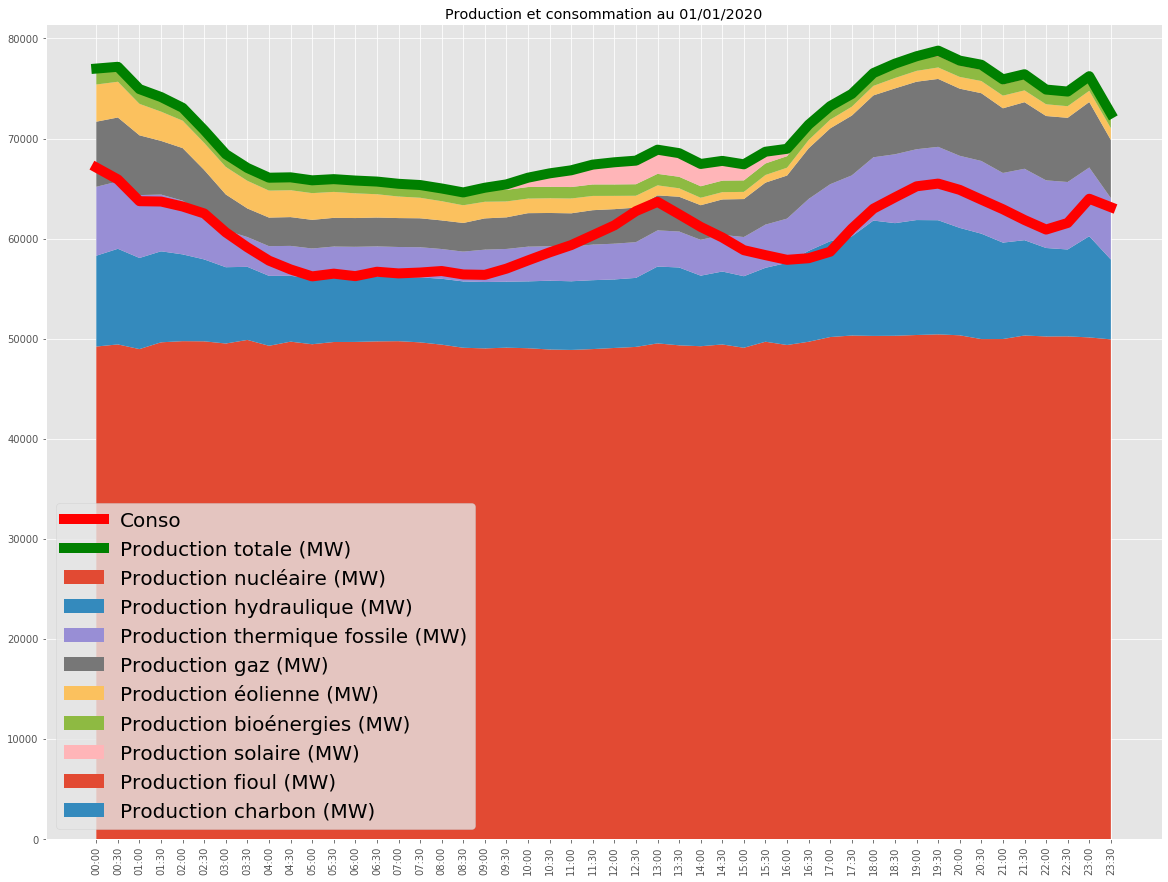

In [192]:
plt.figure(figsize=(20,15))
plt.plot(prod['Heure'],conso['Consommation brute électricité (MW) - RTE'],label='Conso',linewidth=10,c="red")
plt.plot(prod['Heure'],cumul_df['Production totale (MW)'],c='green',linewidth=10,label='Production totale (MW)')
plt.ylim(0,max(prod['Production totale (MW)'])+10000)
plt.xticks(prod['Heure'],prod['Heure'], rotation='vertical')
plt.legend()
for (i,col) in enumerate(cumul_df.columns[:-1]):
    if i == 0:
         plt.fill_between(prod['Heure'],[0]*len(cumul_df),cumul_df.iloc[:,i],label=col)

    else: 
         plt.fill_between(prod['Heure'],cumul_df.iloc[:,i-1],cumul_df.iloc[:,i],label=col)
plt.legend(prop={'size':20})
plt.title('Production et consommation au 01/01/2020')
plt.show()

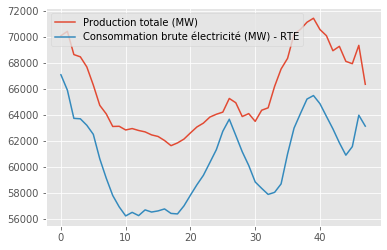

In [48]:
prod['Production totale (MW)'].plot()
conso['Consommation brute électricité (MW) - RTE'].plot()
plt.legend()

In [ ]:
prod['P']